In [1]:
import vtk
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
T = 1200  # number of timesteps performed

arraynames = ["diameter","pressure","velocity", "iters"]   # Which dataset should be plotted?
data_path = "./output_first_mu_rom/out_fluid_"  # Where is the data?


def file_name_generator(id): return data_path + str(id) + ".vtk"


print("parsing datasets named %s*.vtk" % data_path)

values_for_all_t = T * [None]

dx = .1
dt = .1
N = 100
mesh = np.arange(0, dx*(N+1), dx)
time = np.arange(0, dt*T, dt)+dt

parsing datasets named ./output_first_mu_rom/out_fluid_*.vtk


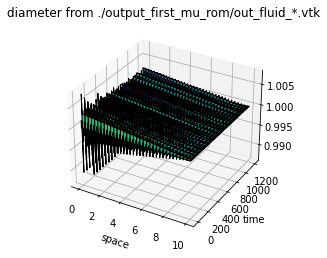

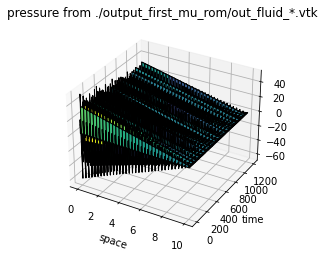

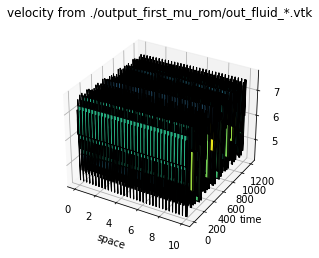

In [3]:
data_ = []
for name in arraynames:
    for t in range(T):

        # read the vtk file as an unstructured grid
        reader = vtk.vtkUnstructuredGridReader()
        reader.SetFileName(file_name_generator(t))
        reader.ReadAllVectorsOn()
        reader.ReadAllScalarsOn()
        reader.Update()

        # parse the data
        grid = reader.GetOutput()
        point_data = grid.GetPointData().GetArray(name)
        points = grid.GetPoints()
        N = grid.GetNumberOfPoints()  # How many gridpoints do exist?

        if point_data is None:  # check if array exists in dataset
            print("array with name %s does not exist!" % name)
            print("exiting.")
            quit()

        value_at_t = []
        spatial_mesh = []

        n = point_data.GetNumberOfComponents()

        for i in range(N):  # parse data from vtk array into list

            x, y, z = grid.GetPoint(i)  # read coordinates of point
            spatial_mesh += [x]  # only store x component

            v = np.zeros(n)  # initialize empty butter array
            point_data.GetTuple(i, v)  # read value into v
            value_at_t += [v[0]]

        values_for_all_t[t] = value_at_t


    values_for_all_t = np.array(values_for_all_t)
    
    data_.append(values_for_all_t.copy().T)
        
    if name != "iters":
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        X, Y = np.meshgrid(spatial_mesh, range(T))

        # uncomment depending on what quantity you want to plot
        ax.plot_surface(X, Y, values_for_all_t, cmap='viridis', edgecolor='black');
        plt.xlabel("space");
        plt.ylabel("time");
        plt.title(name + " from " + data_path + "*.vtk");
        plt.show();
data_[3] = data_[3][0, :].copy()

In [4]:
fom_pressure = np.load("./FOM_DATA/first_mu/pressure.npy")
fom_section = np.load("./FOM_DATA/first_mu/diameter.npy")
fom_velocity = np.load("./FOM_DATA/first_mu/velocity.npy")
iters_fom = np.load("./FOM_DATA/first_mu/iters.npy")

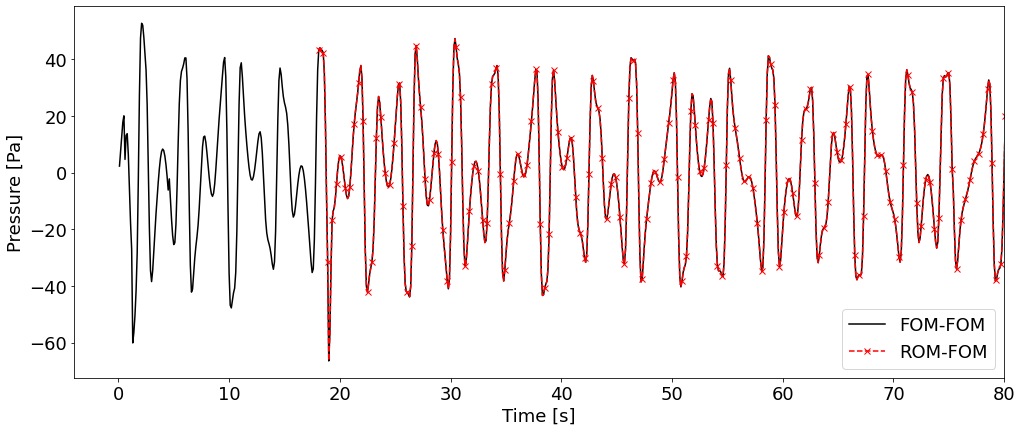

In [5]:
fig, ax = plt.subplots(figsize = (14, 6))

plt.plot(time, fom_pressure[0, :], '-', markevery = 4, color = 'k', label = 'FOM-FOM');
plt.plot(time[180:], data_[1][0, 180:], 'x--', markevery = 4, label = 'ROM-FOM', color = 'red');

plt.xlim(-4., 80.);
plt.xlabel("Time [s]", fontsize = 18)
plt.ylabel("Pressure [Pa]", fontsize = 18)
plt.tight_layout();
plt.legend(fontsize = 18);
ax.tick_params(axis='both', which='major', labelsize=18)
#fig.savefig("tube_pred.pdf", bbox_inches = 'tight');

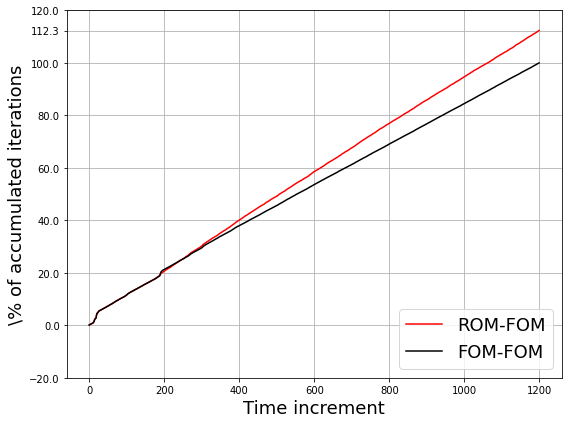

In [6]:
fig, ax= plt.subplots(figsize = (8, 6));
plt.plot(100*np.cumsum(data_[3])/np.cumsum(iters_fom)[-1], color = 'red', markersize = 6, label = "ROM-FOM");
plt.plot(100*np.cumsum(iters_fom)/np.cumsum(iters_fom)[-1], color = 'k', markersize = 6, label = "FOM-FOM");
last_ = (100*np.cumsum(data_[3])/np.cumsum(iters_fom)[-1])[-1]
x_ticks = np.append(ax.get_yticks(), last_)
ax.set_yticks(x_ticks)

plt.xlabel("Time increment", fontsize = 18);
plt.ylabel("\% of accumulated iterations", fontsize = 18);
plt.legend(fontsize = 18, loc = 'lower right');
plt.grid();

plt.tight_layout();
#plt.savefig("TOMAC_iters_tube_.eps", bbox_inches = 'tight');


In [7]:
freq = 2.
pres = 120.
c = -.002
ntt = 1200
dt = .1
b = 0.
d2 = 3.
e = -.02
a = -1.
d1 = -1


def p(t): return pres * np.cos(freq * t)

def d(t): return d1 + d2 * p(t)
def v_dot(u, v, t): return c * u**3 + b * u**2 + a * u + d(t) + e * v

input_t = np.arange(ntt)*dt

from scipy.integrate import solve_ivp
def f(t, y): return np.array([y[1], v_dot(y[0], y[1], t)])
sol = solve_ivp(f, [0, ntt*dt], np.array([10., 0]), t_eval=input_t)


v_int = sol.y[0][(time/dt).astype(int)-1]/60. + 6.


In [8]:
freq = .9
pres = 120.
c = -.002
ntt = 1200
dt = .1
b = 0.
d2 = 3.
e = -.02
a = -1.
d1 = -1


def p(t): return pres * np.cos(freq * t)

def d(t): return d1 + d2 * p(t)
def v_dot(u, v, t): return c * u**3 + b * u**2 + a * u + d(t) + e * v

input_t = np.arange(ntt)*dt

from scipy.integrate import solve_ivp
def f(t, y): return np.array([y[1], v_dot(y[0], y[1], t)])
sol = solve_ivp(f, [0, ntt*dt], np.array([10., 0]), t_eval=input_t)


v_int2 = sol.y[0][(time/dt).astype(int)-1]/60. + 4.


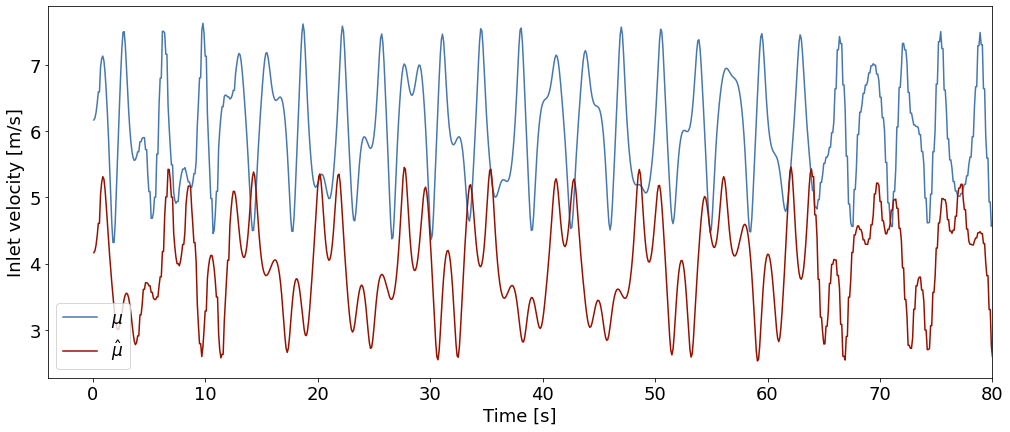

In [9]:
fig, ax = plt.subplots(figsize = (14, 6))

plt.plot(time, v_int, color = (0.2745, 0.4666, 0.68627), label = r'$\mu$');
plt.plot(time, v_int2, color = (0.58, 0.0666, 0), label = r'$\hat{{\mu}}$');

plt.xlim(-4., 80.);
plt.xlabel("Time [s]", fontsize = 18,)
plt.ylabel("Inlet velocity [m/s]", fontsize = 18)
plt.tight_layout();
plt.legend(fontsize = 17);
ax.tick_params(axis='both', which='major', labelsize=18)

#plt.savefig("Inlet_v.pdf", bbox_inches = 'tight')

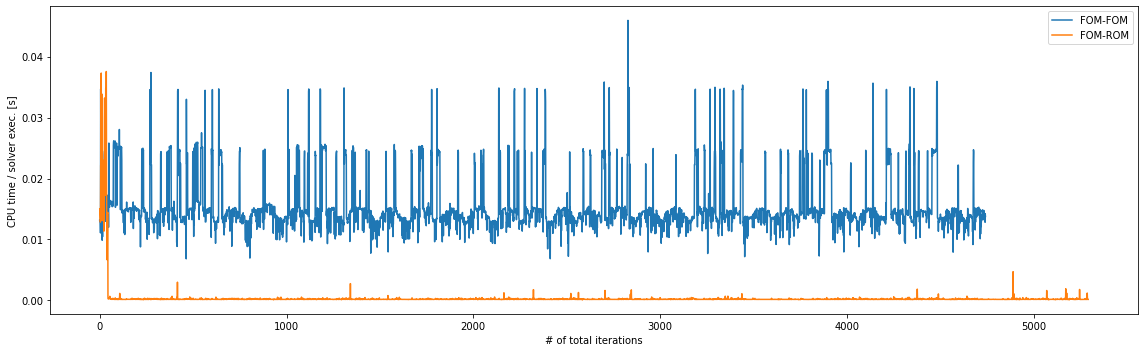

In [4]:
# Only do when times_sol.npy is generated after running the ROM-FOM
times_sol = np.load("./solid/times_sol.npy")
times_sol_fom = np.load("./FOM_DATA/first_mu/times_sol.npy")

fig = plt.figure(figsize=(16, 5))
plt.plot(times_sol_fom, label = 'FOM-FOM')
plt.plot(times_sol, label = 'FOM-ROM');
plt.xlabel("# of total iterations");
plt.ylabel("CPU time / solver exec. [s]");
plt.legend()
plt.tight_layout();

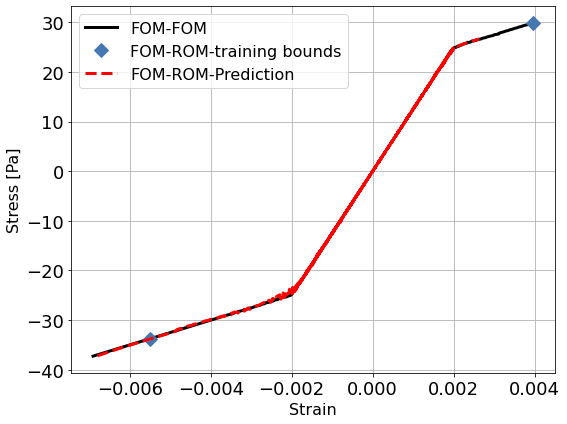

In [10]:
fig3, ax3 = plt.subplots(figsize = (8,6))

node = 0
r0 = 1 / np.sqrt(np.pi)
fom_strain = (np.sqrt(fom_section/np.pi)-r0)/r0
fom_r = np.sqrt(fom_section/(np.pi))
fom_stress = fom_pressure*fom_r

section = data_[0]
strain = (np.sqrt(section/np.pi)-r0)/r0
r = np.sqrt(section/(np.pi))
stress = data_[1]*r

ids_ = np.argsort(fom_strain.ravel())
ax3.plot(np.sort(fom_strain.ravel()), np.sort(fom_stress.ravel()), '-', linewidth = 3, color = 'k', label = "FOM-FOM");
ax3.tick_params(axis='both', which='major', labelsize=18)

ids_rom = np.argsort(strain[:, :180].ravel())
ids_romMin = np.argmin(strain[:, :180].ravel())
ids_romMax = np.argmax(strain[:, :180].ravel())

ax3.plot(strain[:, :180].ravel()[[ids_romMin, ids_romMax]], 
                                 stress[:, :180].ravel()[[ids_romMin, ids_romMax]], 'D', 
          color = (0.2745, 0.4666, 0.68627),
         markersize = 10, label = "FOM-ROM-training bounds");

#ax3.plot(strain[:, :180].ravel()[ids_rom], stress[:, :180].ravel()[ids_rom], 'x--', markevery = 120, label = "FOM-ROM-training");
ids_rom2 = np.argsort(strain[:, 180:].ravel())
ax3.plot(strain[:, 180:].ravel()[ids_rom2], stress[:, 180:].ravel()[ids_rom2], '--', linewidth = 3, color = 'red', label = "FOM-ROM-Prediction");

ax3.set_xlabel("Strain", fontsize = 16);
ax3.set_ylabel("Stress [Pa]", fontsize = 16);
plt.legend(fontsize = 16);
plt.grid();
plt.tight_layout();

#plt.savefig("mAc_strstrn_tst.pdf", bbox_inches = 'tight',)